<a href="https://colab.research.google.com/github/Jonathanpro/myaiblog/blob/master/_notebooks/2021-07-07-huggingface_multi_class_pytorch_evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP -  Multi Class Classification - Evaluate
> A tutorial for evaluating a multi class classifier with Huggingface & Pytroch.

- toc: true 
- badges: true
- comments: false
- categories: [jupyter, NLP, TPU]
- image: images/chart-preview.png

# Usecase: Classify titles of news headline to specific categories
### Train model
---


Load previous trained model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 6.6MB/s 
     |████████████████████████████████| 901kB 38.1MB/s 
     |████████████████████████████████| 3.3MB 24.0MB/s 


In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 149.9MB 83kB/s 
     |████████████████████████████████| 61kB 3.0MB/s 
ERROR: earthengine-api 0.1.269 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


In [ ]:
# Importing the libraries needed
import pandas as pd
import numpy as np
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [ ]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2021-07-06 10:02:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  33.3MB/s    in 0.8s    

2021-07-06 10:02:08 (33.3 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [ ]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
# Import the csv into pandas dataframe and add the headers
df = pd.read_csv('newsCorpora.csv', sep='\t', names=['ID','TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
# df.head()
# # Removing unwanted columns and only leaving title of news and the category which will be the target
df = df[['TITLE','CATEGORY']]
# df.head()

# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    'e':'Entertainment',
    'b':'Business',
    't':'Science',
    'm':'Health'
}

def update_cat(x):
    return my_dict[x]

df['CATEGORY'] = df['CATEGORY'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['CATEGORY'].apply(lambda x: encode_cat(x))
labels = list(df['CATEGORY'].unique())
df_mapping=df[['CATEGORY', 'ENCODE_CAT']].drop_duplicates()
df_mapping = df_mapping.reset_index()
id2label = pd.Series(df_mapping.CATEGORY,index=df_mapping.ENCODE_CAT).to_dict()

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', id2label=id2label)

In [ ]:
class train_data_class(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        inputs['label'] = torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        del inputs['token_type_ids']
        return inputs
        """
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'label': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
        """
    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network
MAX_LEN = 512
train_size = 0.8
train_dataset = df.sample(frac=train_size,random_state=200)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


training_set = train_data_class(train_dataset, tokenizer, MAX_LEN)
testing_set = train_data_class(test_dataset, tokenizer, MAX_LEN)

In [ ]:
import torch_xla
import torch_xla.core.xla_model as xm

device = xm.xla_device()

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }


training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=1*16,  # batch size per device during training
    per_device_eval_batch_size=1*64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=1000,
) # save_strategy='steps', save_steps=5000 

model = AutoModelForSequenceClassification.from_pretrained("/content/gdrive/MyDrive/MC_03_09_07_05_21.bin", local_files_only=True, num_labels=len(labels), id2label=id2label)
model = model.to(device)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    compute_metrics=compute_metrics,
    train_dataset=training_set,         # training dataset
    eval_dataset=testing_set             # evaluation dataset
)

In [ ]:
result = trainer.predict(training_set)
# np.argmax(result.predictions, axis=1)

***** Running Prediction *****
  Num examples = 337935
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_dataset['ENCODE_PRED'] = np.argmax(result.predictions, axis=1)
train_dataset.head()

,TITLE,CATEGORY,ENCODE_CAT,ENCODE_PRED
0,President Barack Obama Releases Statement Abou...,Entertainment,2,2
1,GoPro files to go public,Business,0,0
2,St. Patrick's Day trivia,Entertainment,2,2
3,Bill Murray Enters the Oscar Race,Entertainment,2,2
4,US safety agency probes older Ram pickup truck...,Science,1,1


How to build a confusion matrix

https://deeplizard.com/learn/video/0LhiS6yu2qQ


Confusion matrix, without normalization
[[ 92212    371     99     70]
 [   546  85887     72     26]
 [    98     62 121905     27]
 [   106     34     60  36360]]


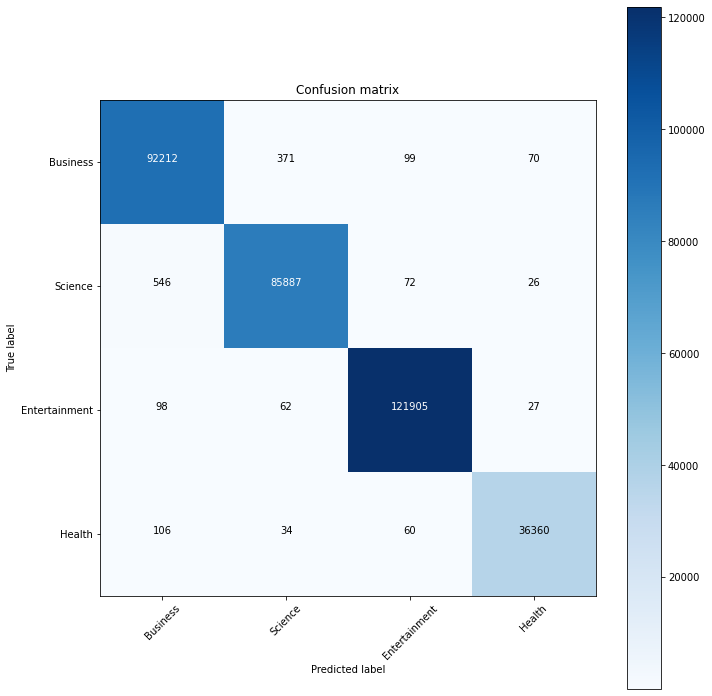

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(train_dataset['ENCODE_CAT'], train_dataset['ENCODE_PRED'])

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, labels)


TODO explanation for confusion matrix

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 84484
  Batch size = 64
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'eval_accuracy': 0.9565834950996639,
 'eval_loss': 0.2912846505641937,
 'eval_runtime': 851.0253,
 'eval_samples_per_second': 99.273,
 'eval_steps_per_second': 1.552}

TODO calcluate & interpre results